In [ ]:
# data handling
import pandas as pd
import numpy as np

# viz
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
#import FCPython 
#from mplsoccer import Pitch, VerticalPitch
#from mplsoccer.utils import FontManager
#from highlight_text import HighlightText, ax_text, fig_text

# model
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space
from sklearn.decomposition import PCA
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import cv
from imblearn.over_sampling import RandomOverSampler

# stats
from numpy import mean, std 
from numpy.ma.core import count

# file management (include this block only if running on Google Colab)
# from google.colab import files
# import io

In [ ]:
# File upload for Google Colab (include this block only if running on Google Colab)
#uploaded = files.upload()

Saving final_pred_data.csv to final_pred_data.csv


In [ ]:
# For Google Colab ONLY
# df = pd.read_csv(io.BytesIO(uploaded['final_pred_data.csv']))

In [ ]:
# Normal CSV load
df = pd.read_csv('../../Datasets/final_pred_data.csv')

In [ ]:
# View shape of data
df.shape

(380, 12)

In [ ]:
df.head()

,matchID,home,away,home_elo,away_elo,home_xG,home_xA,away_xG,away_xA,home_goals,away_goals,outcome
0,1,Manchester United,Burnley,1922.345825,1716.901733,1.181875,0.8,0.746279,0.4,1,0,Home Win
1,2,Aston Villa,Manchester City,1731.870361,2014.916016,0.725715,0.5,3.514548,2.2,0,2,Away Win
2,3,Crystal Palace,Southampton,1694.026489,1706.798462,0.692866,0.7,0.946968,0.6,1,0,Home Win
3,4,Fulham,Arsenal,1633.599243,1857.283325,0.206295,0.1,2.050351,1.0,0,3,Away Win
4,5,Liverpool,Leeds United,1933.287354,1775.257202,1.908688,1.5,0.443968,0.3,4,3,Home Win


#### Pre-processing

In [ ]:
# Label encdoing for targets

# define encoder
encoder = LabelEncoder()

df['outcome'] = encoder.fit_transform(df['outcome'])

df.head()

,matchID,home,away,home_elo,away_elo,home_xG,home_xA,away_xG,away_xA,home_goals,away_goals,outcome
0,1,Manchester United,Burnley,1922.345825,1716.901733,1.181875,0.8,0.746279,0.4,1,0,2
1,2,Aston Villa,Manchester City,1731.870361,2014.916016,0.725715,0.5,3.514548,2.2,0,2,0
2,3,Crystal Palace,Southampton,1694.026489,1706.798462,0.692866,0.7,0.946968,0.6,1,0,2
3,4,Fulham,Arsenal,1633.599243,1857.283325,0.206295,0.1,2.050351,1.0,0,3,0
4,5,Liverpool,Leeds United,1933.287354,1775.257202,1.908688,1.5,0.443968,0.3,4,3,2


In [ ]:
# 0 - Away Win | 1 - Draw | 2- Home Win
print(len(df.loc[df['outcome'] == 0]))
print(len(df.loc[df['outcome'] == 1]))
print(len(df.loc[df['outcome'] == 2]))

144
83
153


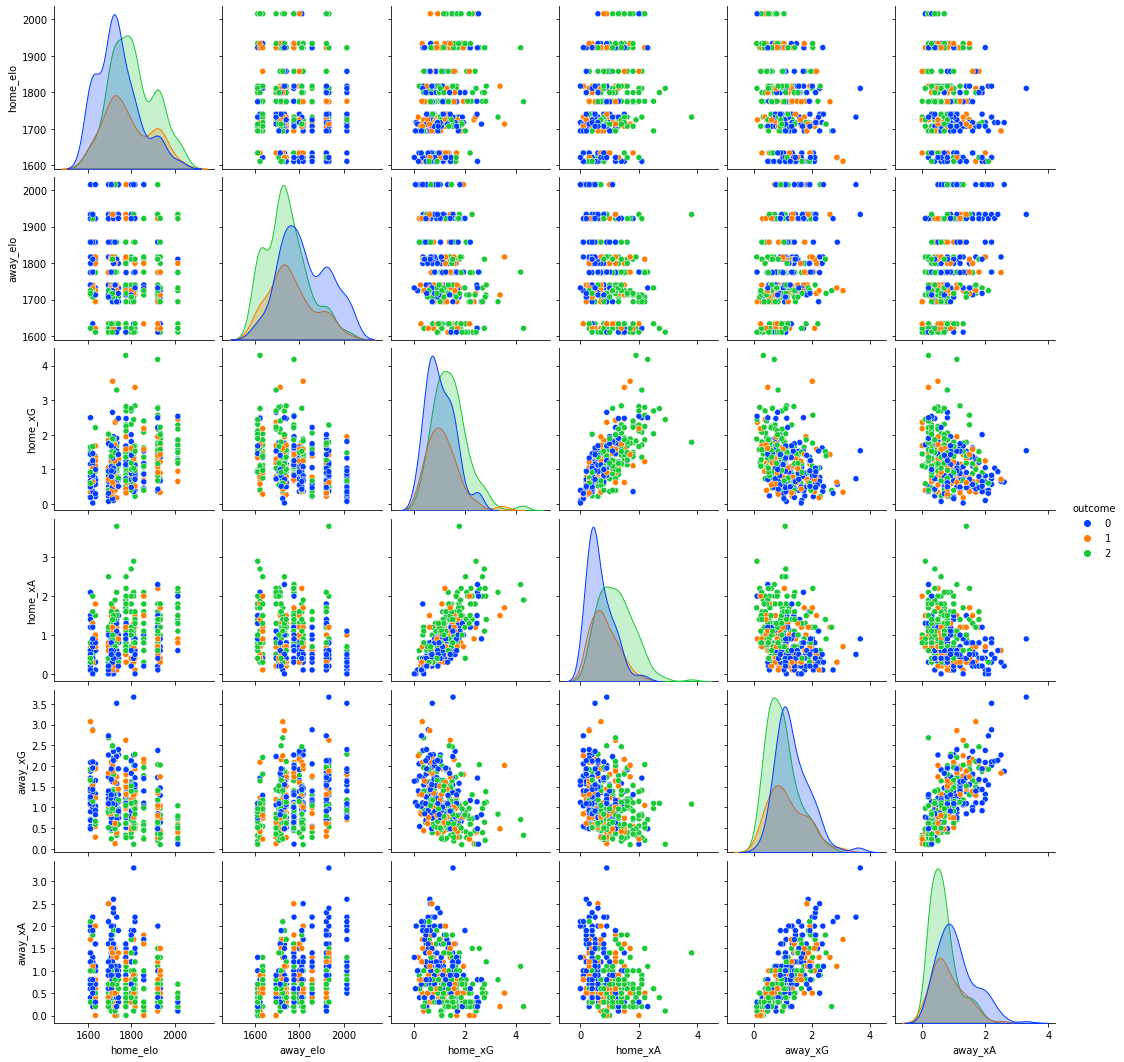

In [ ]:
# Display target data distribtion based on features
df_plot = df.drop(['matchID','home','away','home_goals','away_goals'], axis=1)
sns.pairplot(df_plot, hue="outcome",palette="bright")

In [ ]:
#Shuffle dataset
df = df.sample(frac = 1)

### xGBoost with splitting method + GridSearchCV (Hyperparameter Tuning)


#### Pre-processing

In [ ]:
# Set independent variables and targets
X = df[['home_elo', 'away_elo', 'home_xG','home_xA','away_xG','away_xA']]
y = df['outcome']

In [ ]:
# Oversampling to handle imbalanced data
ros = RandomOverSampler(random_state=42)
variablex_ros, y_ros = ros.fit_resample(X, y)

print('Original dataset shape', count(y))
print('Resample dataset shape', count(y_ros))

Original dataset shape 380
Resample dataset shape 459


In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(variablex_ros, y_ros, test_size=0.2, random_state=42, stratify=y_ros)
# Check the number of records in training and testing dataset.
print(f'The training dataset has {len(X_train)} records.')
print(f'The testing dataset has {len(X_test)} records.')

The training dataset has 367 records.
The testing dataset has 92 records.


In [ ]:
# Normalisation

# Initiate scaler
sc = StandardScaler()
# Standardize the training dataset
X_train_norm = pd.DataFrame(sc.fit_transform(X_train),index=X_train.index, columns=X_train.columns)
# Standardized the testing dataset
X_test_norm = pd.DataFrame(sc.transform(X_test),index=X_test.index, columns=X_test.columns)
# Summary statistics after standardization
X_train_norm.describe().T

,count,mean,std,min,25%,50%,75%,max
home_elo,367.0,-4.732959e-16,1.001365,-1.576879,-0.646657,0.003711,0.416079,2.333583
away_elo,367.0,9.438408e-16,1.001365,-1.585016,-0.626967,-0.371200,0.540170,2.210814
home_xG,367.0,-9.037578e-17,1.001365,-1.728988,-0.712982,-0.156004,0.512662,4.655159
home_xA,367.0,-9.929992e-17,1.001365,-1.574603,-0.853831,-0.313251,0.587714,5.272737
away_xG,367.0,-5.626743e-17,1.001365,-1.745966,-0.731687,-0.179291,0.620965,3.837712
away_xA,367.0,-8.712377e-17,1.001365,-1.597231,-0.656326,-0.279964,0.566850,3.295475


In [ ]:
# Dimensionality reduction

# PCA Implementation
pca = PCA(n_components=3)
X_train_transformed = pca.fit_transform(X_train_norm)
X_test_transformed = pca.transform(X_test_norm)

In [ ]:
# Hyperparameter Tuning
# Define search space for hyperparameters

param_grid = {
    # Learning tasks
    "objective": ["multi:softmax"],
    # Number of classes
    "num_class": [3],
    # Number of decision trees
    "n_estimators": [10, 50, 100, 500 ,1000],
    # Learning rate
    "learning_rate": [0.05, 0.1, 0.2, 0.5],
    # Maximum levels allowed
    "max_depth": [6], #[2, 3, 4, 6, 8, 10, 12],
    # Minimum sum of each instance weight needed in a child
    "min_child_weight": [1], #[1, 2, 3, 4, 5, 6],
    # Minimum loss reduction required to make a further partition on a leaf node of the tree
    "gamma": [0.01], #[0.01, 0.5, 0.1, 0.2, 0.3, 0.4],
    # Fractions of observations to be randomly samples for each tree
    "subsample": [0.8], #[0.2, 0.3, 0.4, 0.5, 0.6, 0.8],
    "colsample_bytree": [0.8], #[0.2, 0.3, 0.4, 0.5, 0.6, 0.8],
    # Regularization
    "alpha": [0], #, 0.01, 0.1, 1, 100],
    # Maximum delta step allowed for each tree's weight estimation
    "max_delta_step": [3] #1, 2, 3, 4, 5]
    }

# Set up score
scoring = ['accuracy','f1_macro']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# Initialize model
xgb_model = XGBClassifier()

In [ ]:
# Define grid search
grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           refit='accuracy', 
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=0)
# Fit grid search
grid_result = grid_search.fit(X_train_transformed, y_train)

xgb_pred=grid_search.predict(X_test_transformed)

# Print grid search summary
grid_result

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'alpha': [0], 'colsample_bytree': [0.8],
                         'gamma': [0.01],
                         'learning_rate': [0.05, 0.1, 0.2, 0.5],
                         'max_delta_step': [3], 'max_depth': [6],
                         'min_child_weight': [1],
                         'n_estimators': [10, 50, 100, 500, 1000],
                         'num_class': [3], 'objective': ['multi:softmax'],
                         'subsample': [0.8]},
             refit='accuracy', scoring=['accuracy', 'f1_macro'])

In [ ]:
# Print the best accuracy score for the training dataset
print(f'The best accuracy score for the training dataset: {grid_result.best_score_:.4f}')
# Print the hyperparameters for the best score
print(f'The best hyperparameters: {grid_result.best_params_}')
# Print the scores for the testing dataset
print(f'Accuracy on the testing dataset: {grid_search.score(X_test_transformed, y_test):.4f}') # Best:
print('F1 Score on the testing dataset: {:.4f}' .format(metrics.f1_score(y_test, xgb_pred, average='weighted'))) # Best:

The best accuracy score for the training dataset: 0.6378
The best hyperparameters: {'alpha': 0, 'colsample_bytree': 0.8, 'gamma': 0.01, 'learning_rate': 0.1, 'max_delta_step': 3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'num_class': 3, 'objective': 'multi:softmax', 'subsample': 0.8}
Accuracy on the testing dataset: 0.7283
F1 Score on the testing dataset: 0.7234


Confusion Matrix
 [[23  3  4]
 [ 3 27  1]
 [10  4 17]]


[Text(0, 0.5, '0'), Text(0, 1.5, '1'), Text(0, 2.5, '2')]

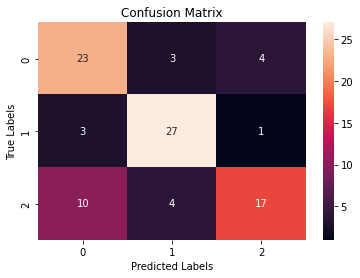

In [ ]:
# Plot Confusion Matrix
labels = [0,1,2]
cm = confusion_matrix(y_test, xgb_pred) #add 'labels' in the '()' for older version of sklearn
print("Confusion Matrix\n", cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels([0,1,2])
ax.yaxis.set_ticklabels([0,1,2])

#### xGBoost with splitting method + Genetic Algortithm (Hyperparameter Tuning)

In [ ]:
param_grid = {
    # Learning tasks
    "objective": Categorical(["multi:softmax"]),
    # Number of classes
    "num_class": Integer(3,3),
    # Number of decision trees
    "n_estimators": Integer(10, 1000, distribution='uniform'),
    # Learning rate
    "learning_rate": Continuous(0.05, 0.5, distribution='uniform'),
    # Maximum levels allowed
    "max_depth": Integer(2, 12, distribution='uniform'),
    # Minimum sum of each instance weight needed in a child
    "min_child_weight": Integer(1,6,distribution='uniform'),
    # Minimum loss reduction required to make a further partition on a leaf node of the tree
    "gamma": Continuous(0.01,0.4, distribution='uniform'), #[0.01, 0.5, 0.1, 0.2, 0.3, 0.4],
    # Fractions of observations to be randomly samples for each tree
    "subsample": Continuous(0.2,0.8, distribution='uniform'), #[0.2, 0.3, 0.4, 0.5, 0.6, 0.8],
    "colsample_bytree": Continuous(0.2,0.8, distribution='uniform'), #[0.2, 0.3, 0.4, 0.5, 0.6, 0.8],
    # Regularization
    "alpha": Continuous(0, 100, distribution='uniform'), #, 0.01, 0.1, 1, 100],
    # Maximum delta step allowed for each tree's weight estimation
    "max_delta_step": Integer(1,5, distribution='uniform') #1, 2, 3, 4, 5]
    }

# Set up score
scoring = ['accuracy','f1_macro']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# Initialize model
xgb_model = XGBClassifier()

In [ ]:
evolved_estimator = GASearchCV(estimator=xgb_model,
                               cv=kfold,
                               scoring='accuracy',
                               population_size=10,
                               generations=35,
                               tournament_size=3,
                               elitism=True,
                               crossover_probability=0.8,
                               mutation_probability=0.05,
                               param_grid=param_grid,
                               criteria='max',
                               algorithm='eaMuPlusLambda',
                               n_jobs=-1,
                               verbose=True,
                               keep_top_k=4)

In [ ]:
evolved_estimator.fit(X_train_transformed,y_train)
y_predict_ga = evolved_estimator.predict(X_test_transformed)

accuracy = metrics.accuracy_score(y_test,y_predict_ga)
f1= metrics.f1_score(y_test,y_predict_ga, average='weighted')

print("Accuracy: {}" .format(accuracy))
print("F1 Score: {}" .format(f1))

gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	10    	0.56723	0.0322448  	0.602477   	0.514715   
1  	17    	0.589377	0.0188448  	0.602477   	0.539414   
2  	18    	0.601929	0.00506721 	0.610511   	0.594369   
3  	16    	0.60798 	0.00610486 	0.616291   	0.597147   
4  	17    	0.613491	0.00280102 	0.616291   	0.610511   
5  	19    	0.615713	0.00166052 	0.616291   	0.610736   
6  	17    	0.616291	0          	0.616291   	0.616291   
7  	17    	0.616291	0          	0.616291   	0.616291   
8  	16    	0.616291	0          	0.616291   	0.616291   
9  	18    	0.616291	0          	0.616291   	0.616291   
10 	17    	0.616291	0          	0.616291   	0.616291   
11 	18    	0.616291	0          	0.616291   	0.616291   
12 	19    	0.616291	0          	0.616291   	0.616291   
13 	17    	0.616291	0          	0.616291   	0.616291   
14 	14    	0.616291	0          	0.616291   	0.616291   
15 	19    	0.616291	0          	0.616291   	0.616291   
16 	16    	0.616291	0          	0.616291   	0.6162

Confusion Matrix
 [[20  6  4]
 [ 1 29  1]
 [ 8  4 19]]


[Text(0, 0.5, '0'), Text(0, 1.5, '1'), Text(0, 2.5, '2')]

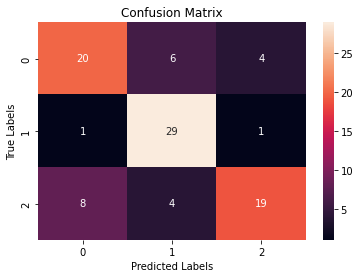

In [ ]:
# Plot Confusion Matrix
labels = [0,1,2]
cm = confusion_matrix(y_test, y_predict_ga) #add 'labels' in the '()' for older version of sklearn
print("Confusion Matrix\n", cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels([0,1,2])
ax.yaxis.set_ticklabels([0,1,2])


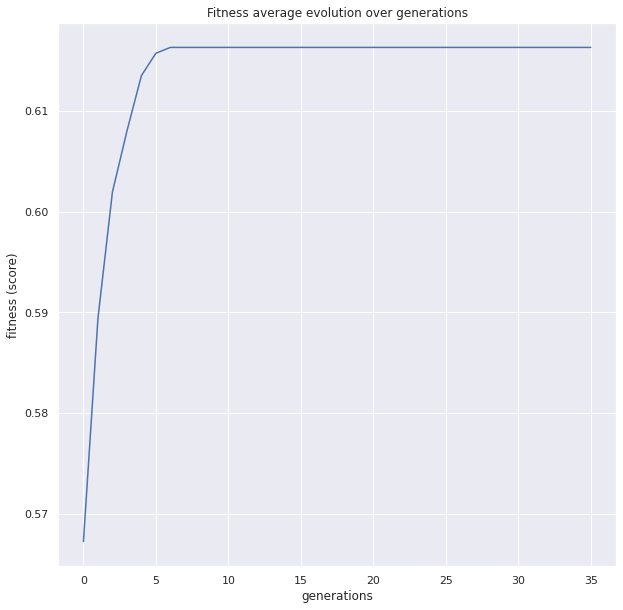

In [ ]:
plot_fitness_evolution(evolved_estimator)
plt.show()

In [ ]:
# Show best hyperparameters
evolved_estimator.best_params_

{'alpha': 21.60624160131528,
 'colsample_bytree': 0.24356144056567358,
 'gamma': 0.3082372492137308,
 'learning_rate': 0.1967598546428948,
 'max_delta_step': 1,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 589,
 'num_class': 3,
 'objective': 'multi:softmax',
 'subsample': 0.4755725291389338}

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping dens

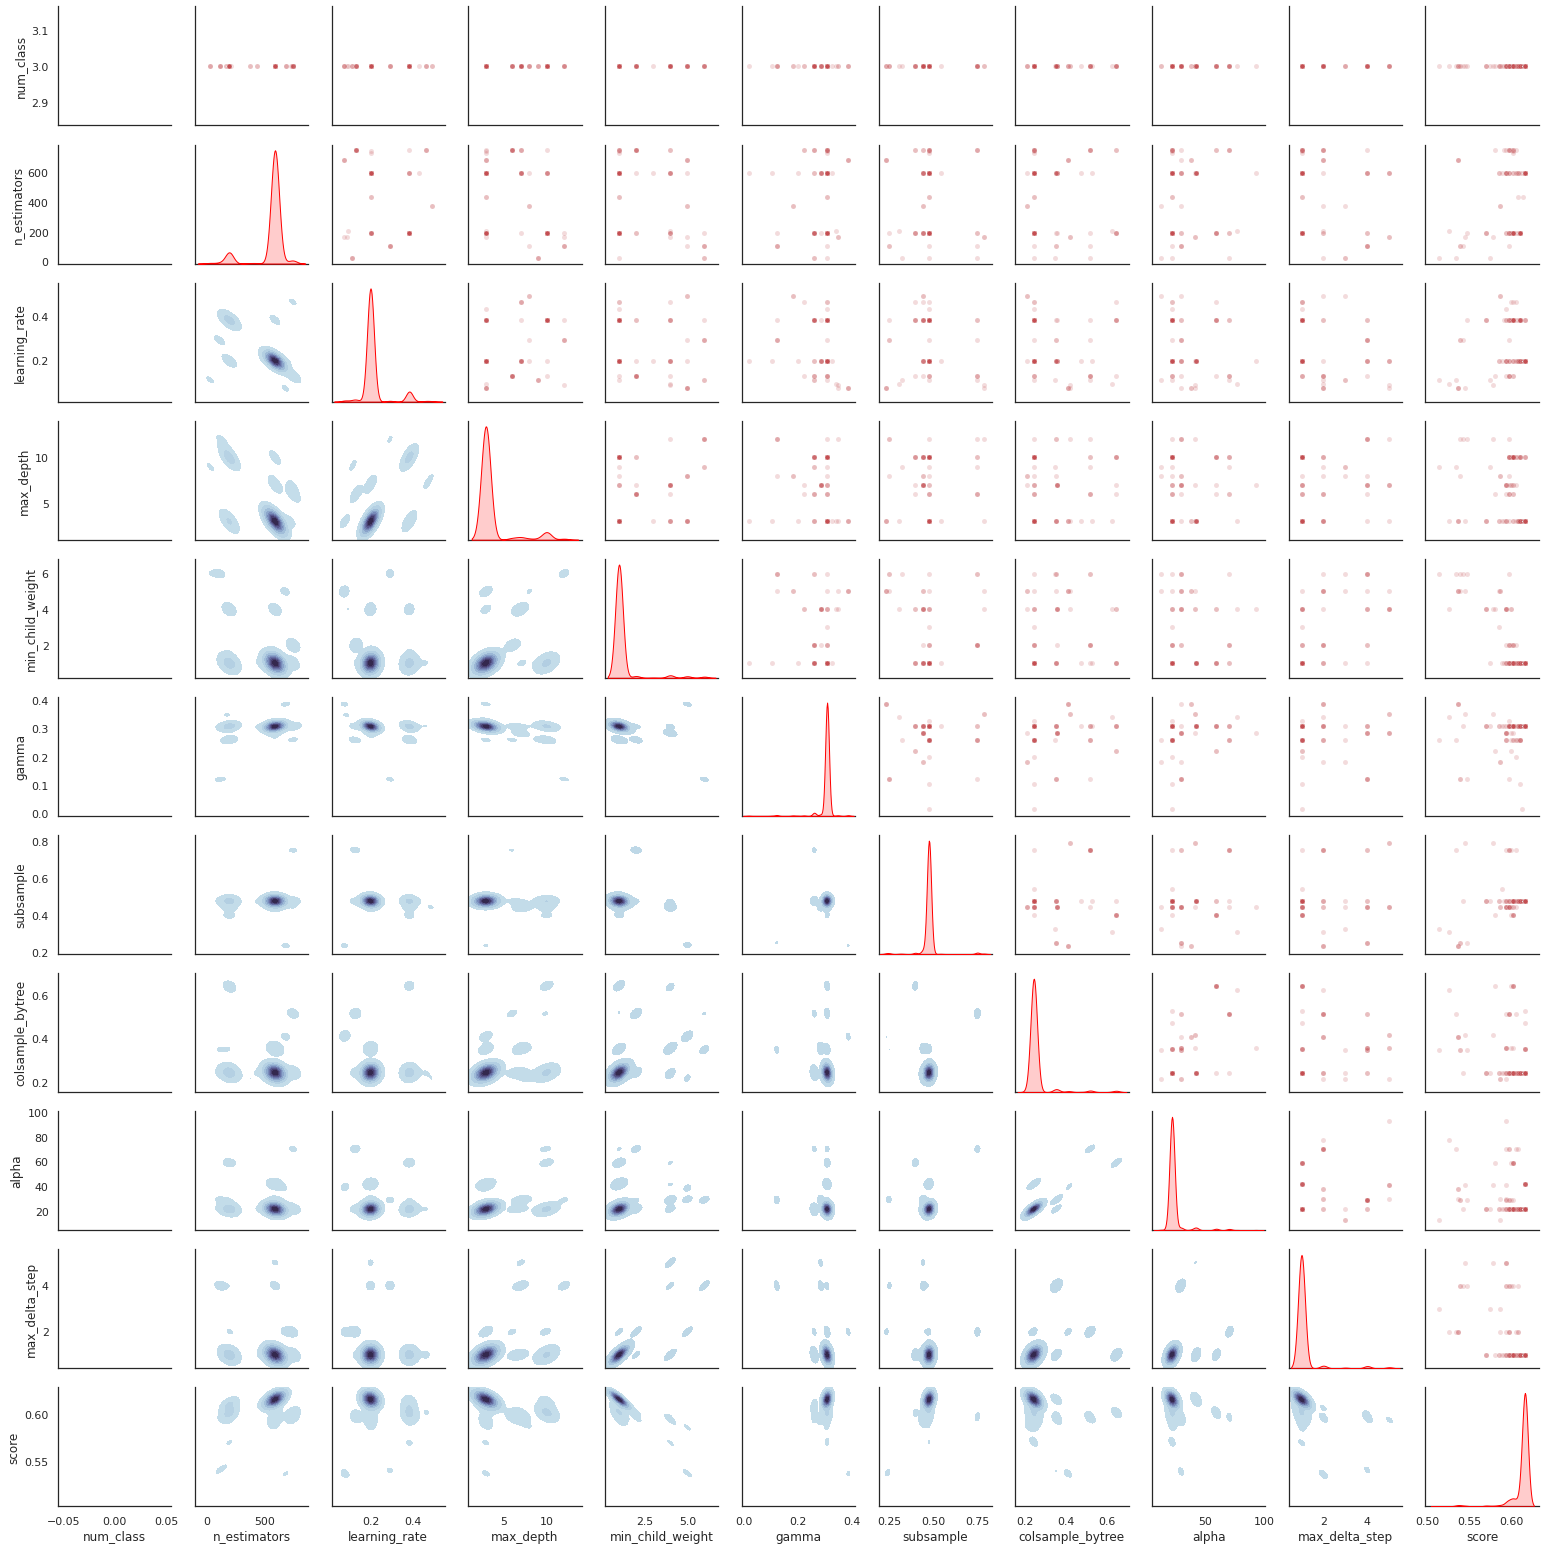

In [ ]:
# Show search space
plot_search_space(evolved_estimator)
plt.show()

In [ ]:
# Show top 4 solutions
print("Best 4 solutions:\n")
evolved_estimator.hof

Best 4 solutions:



{0: {'alpha': 21.60624160131528,
  'colsample_bytree': 0.24356144056567358,
  'gamma': 0.3082372492137308,
  'learning_rate': 0.1967598546428948,
  'max_delta_step': 1,
  'max_depth': 3,
  'min_child_weight': 1,
  'n_estimators': 589,
  'num_class': 3,
  'objective': 'multi:softmax',
  'subsample': 0.4755725291389338},
 1: {'alpha': 21.60624160131528,
  'colsample_bytree': 0.35205702092277436,
  'gamma': 0.3082372492137308,
  'learning_rate': 0.1967598546428948,
  'max_delta_step': 1,
  'max_depth': 3,
  'min_child_weight': 1,
  'n_estimators': 589,
  'num_class': 3,
  'objective': 'multi:softmax',
  'subsample': 0.4755725291389338},
 2: {'alpha': 41.942258749816766,
  'colsample_bytree': 0.24356144056567358,
  'gamma': 0.3082372492137308,
  'learning_rate': 0.1967598546428948,
  'max_delta_step': 1,
  'max_depth': 3,
  'min_child_weight': 1,
  'n_estimators': 589,
  'num_class': 3,
  'objective': 'multi:softmax',
  'subsample': 0.4755725291389338},
 3: {'alpha': 21.60624160131528,
  '